In [1]:
import pickle
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.cluster import KMeans
import re
from sklearn.decomposition import PCA
from collections import *
from scipy.signal import butter, filtfilt
from collections import Counter
import seaborn as sns
import scipy.signal as signal
from scipy.spatial.distance import cityblock
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.backends.backend_pdf
import math

file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_breath1.obj", "rb")
trials_breath = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\static_data.obj", "rb")
static_data = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_raw1.obj", "rb")
trials_raw = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_ecg1.obj", "rb")
trials_ecg = pickle.load(file)
metadata = pd.read_csv(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\d2k project metadata.csv")

In [3]:
static_data

,MUID,Line,Genotype,Weight,Mouse Type
0,M21264,hm4d,Exp,4.06,hm4d Exp
1,M21267,hm4d,Exp,3.92,hm4d Exp
2,M21269,hm4d,Exp,5.60,hm4d Exp
3,M21627,hm4d,Con,4.54,hm4d Con
4,M21628,hm4d,Con,5.81,hm4d Con
5,M21630,hm4d,Con,5.65,hm4d Con
6,M20865,hm3d,Exp,3.41,hm3d Exp
7,M20867,hm3d,Exp,3.43,hm3d Exp
8,M20869,hm3d,Exp,4.44,hm3d Exp
9,M20874,hm3d,Exp,3.80,hm3d Exp


In [6]:
trials_ecg

{'M20864': {'ecg':        Unnamed: 0  TimeDate  RR Interval (s)  Heart Rate (BPM)  \
  961         962.0   101.609            0.061        983.599976   
  962         963.0   101.692            0.083        722.900024   
  963         964.0   101.817            0.125        480.000000   
  964         965.0   101.910            0.093        645.200012   
  965         966.0   101.983            0.073        821.900024   
  ...           ...       ...              ...               ...   
  24101     24102.0  4136.156            1.865         32.169998   
  24102     24103.0  4137.786            1.630         36.810001   
  24103     24104.0  4139.825            2.039         29.430000   
  24104     24105.0  4141.930            2.105         28.500000   
  24105     24106.0  4144.163            2.233         26.870001   
  
         PR Interval (s)  P Duration (s)  QRS Interval (s)  QT Interval (s)  \
  961      -1.000000e-07   -1.000000e-07             0.009    -1.000000e-07   
  962 

In [2]:
def butter_bandpass(lowcutoff, highcutoff, fs, order):
    """
    This function takes in the filter parameters and
    does the simple calculations needed to account for the
    Nyquist frequency and using the scipy butter function
    to produce the numerator and polynomials of the IIR filter \n
    Inputs: \n
    1) lowcutoff - lower frequecy cutoff of bandpass filter
    2) highcutoff - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order \n
    Outputs: \n
    1) a - denominator polynomials of the IIR filter
    2) b - numerator polynomials of the IIR filter

    """
    nyq = 0.5 * fs  #nyquist frequency
    lowcutoff = lowcutoff / nyq        
    highcutoff = highcutoff / nyq
    a,b = butter(order, [lowcutoff, highcutoff], analog=False, btype='bandpass',output = 'ba')
    return a,b

def butter_bandpass_filter(data, lowcutoff, highcutoff, fs, order):
    """
    This function wraps the scipy functions needed to implement a 
    bandpass fillter and ultimately filters the signal \n
    Inputs: \n
    1) data - signal to be filtered
    2) lowcutoff - lower frequecy cutoff of bandpass filter
    3) highcutoff - upper frequecy cutoff of bandpass filter
    4) fs - sampling frequency
    5) order - filter order \n
    Outputs: \n
    1) filtered_signal

    """
    a,b = butter_bandpass(lowcutoff, highcutoff, fs, order=order)
    filtered_signal = filtfilt(a,b, data)
    return filtered_signal

def bandpass_filter(low, high, fs,order, signal, quiet = False):
    """
    This function bandpasses filters a given signal and has an option
    of plotting what the signal looks like before and after filtering \n
    Inputs: \n
    1) low - lower frequecy cutoff of bandpass filter
    2) high - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order 
    5) signal - signal to be filtered
    6) quiet - (default: False) boolean indicating whether or not to display signal before and after filtering \n
    Outputs: \n
    1) filtered_data

    """
    filtered_data = butter_bandpass_filter(signal, low, high, fs, order)

    if quiet == False:    
        plt.figure(figsize = (8,8))
        plt.plot(signal, label='Raw signal')
        plt.title("Unfiltered signal", size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

        plt.figure(figsize = (8,8))
        plt.plot(filtered_data)
        plt.title("Bandpass Filtered Signal, Cutoff = {}-{} Hz" .format(low,high), size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

    return filtered_data

def compute_timestamps(metadata, mouse_id, all = False, breath_only = False, phase = None, phase2 = None, phase3 = None, phase4 = None):
    """
    Given the required phase(s) and metadata, this function returns all the timestamps in which
    the given phase occurs in seconds as a list \n  

    Inputs:
    1) metadata
    2) mouse_id
    3) all - (default: False) boolean indicating whether all timestamps in experiments are requested as opposed to a select few
    4) breath_only - (default: False) Only if all == True. Excludes all HR Recovery timestamps when set to true
    5) phase, phase2, ... - all phases requested. At least 1 and at most 5 phases.

    if all == True, all timestamps in the experiment is returned \n
    Output formatted as follows: \n
        timestamps_in_s["trial"] = [list of timestamps] \n
        timestamps_in_s["other"]["timestamp"] = [all timestamps for non-trial onset] \n
        timestamps_in_s["other"]["comment"] = [names of all timestamps for not-trial onset]  \n
    if all == false, only specified timestamps are returned \n
    Output is just a 
    """
        
    if not all:
        #retreiving all relevant timestamps
        timestamps_in_hms = list(metadata[((metadata["Comment"] == phase) | (metadata["Comment"] == phase2) | (metadata["Comment"] == phase3) | (metadata["Comment"] == phase4)) & (metadata["source file"] == mouse_id)]["Time"])
        timestamps_in_s = []
        
        #converting timstamps from h:m:s to seconds
        for timestamp in timestamps_in_hms:
            processed_timestamp = re.split(':', timestamp)
            timestamp = [float(i) for i in processed_timestamp]   
            if len(timestamp) == 1:
                timestamps_in_s.append(timestamp[0])
            elif len(timestamp) == 2:
                timestamps_in_s.append(60*timestamp[0]+timestamp[1])
            elif len(timestamp) == 3:
                timestamps_in_s.append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])

        return timestamps_in_s

    else: #retreive all timestamps in experiment
        comments = list(metadata[metadata["source file"] == mouse_id]["Comment"]) 
        timestamps_in_hms = list(metadata[metadata["source file"] == mouse_id]["Time"]) 
        timestamps_in_s = defaultdict(lambda: defaultdict(str))

        if breath_only:  #exclude HR recovery timestamps
            other_comments = []
            other_timestamps = []
            for timestamp in range(0,len(comments)):
                if comments[timestamp] not in ["HR recovery","Hr recovery","HR recovery - No signal", "hr recovery"]:
                    other_comments.append(comments[timestamp])
                    other_timestamps.append(timestamps_in_hms[timestamp])
            timestamps_in_hms = other_timestamps
            comments = other_comments

        timestamps_in_s["trial"] = []
        timestamps_in_s["other"]["timestamp"] = []
        timestamps_in_s["other"]["comment"] = []

        #converting all hms timestamps 
        for stage in range(0,len(comments)):
            if comments[stage].isdecimal(): #if timestamps is trial onset, it is assigned elsewehere
                processed_timestamp = re.split(':', timestamps_in_hms[stage])
                timestamp = [float(i) for i in processed_timestamp]   
                if len(timestamp) == 1:
                    timestamps_in_s["trial"].append(timestamp[0])
                    timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                elif len(timestamp) == 2:
                    timestamps_in_s["trial"].append(60*timestamp[0]+timestamp[1])
                    timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                elif len(timestamp) == 3:
                    timestamps_in_s["trial"].append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])
                    timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                timestamps_in_s["other"]["comment"].append(comments[stage])
            else:
                if not comments[stage][1:].isdecimal():
                    processed_timestamp = re.split(':', timestamps_in_hms[stage])
                    timestamp = [float(i) for i in processed_timestamp]   
                    if len(timestamp) == 1:
                        timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                    elif len(timestamp) == 2:
                        timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                    elif len(timestamp) == 3:
                        timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                    timestamps_in_s["other"]["comment"].append(comments[stage])

        return timestamps_in_s

def retrieve_phase(meta_data, raw_data, static_data, trial_data,data_type,label1, label2 = None, label3 = None, label4 = None, trial_onset_first = bool, otherlabel = None, otherlabel2 = None):
    """
    Inputs: \n
    1) meta_data (required): metadata \n
    2) raw_data (required):  raw_data \n
    3) static_data (required) \n
    4) trial_data (required): either trials_ecg, trials_breath \n
    5) data_type (required): either "ECG" or "Breathing_flow_signal" \n
    6) trial_onset_first (required): specify whether the desired phase starts or ends with trial onset or not. Set to False if other_label is phase onset \n
    7) label1, label2,.. label4 (optional) (default=None): string representing desired phase timestamp, has multiple options in case the same phase was referenced in different ways in the metadata \n
    8) other_label (optional) (default=None): specify other end of phase if it's not a trial onset (e.g. looking for interval from apnea start to recovery
                 as opposed to looking for phase HR to next trial onset or looking for phase trial onset to apnea start) \n
    
    Outputs: \n
    1) interval_information_df - dataframe on mouse ID and experimental type information encoded as natural numbers for plotting purposes \n
    2) min_interval_length - minimum length of all the phases extracted in this function \n
    3) phase_interval_per_mouse - function mapping each mouse to a mapping from a number to its corresponding phase
                               (i.e 3 phase means 1:phase1, 2:phase2,3:phase3) where each
                                phase is a dataframe \n
    Method: \n
    Upon specificying the desired phase boundaries (HR recovery to trial onset/ trial onset to apnea/ eupnea recovery to trial onset ..etc) \n
    this function returns the desired phases as a dataframe in the format specified above. This function defaults to finding the phases that either \n
    start or ends with trial onset unless other_label is specified in which case other_label offsets that defualt setting in case a start/end \n
    different from trial onset is desired.
    """
    
    mice = list(trial_data.keys())
    phase_interval_per_mouse = defaultdict(lambda : defaultdict(int))
    min_interval_length = float("inf")

    phase_interval_number = []
    mouse_IDs = []
    mouse_ID_no = []
    mouse_type = []
    mouse_type_no = []
    mouse_genotypes = {}
    
    #
    i = 0
    for mouse_line in static_data["Line"].unique():
        for exp_type in static_data["Genotype"].unique():
            i += 1
            mouse_genotypes[mouse_line + " " + exp_type] = i
    j = 0
    #going through all the mice to extract the desired phases from each of their experiments
    for mouse in mice:
        j += 1
        print("Currently retrieving interval information for mouse {0}. Progress: {1}%" .format(mouse,100*((mice.index(mouse) + 1)/len(mice))))

        #different method for extracting the desired phase start/end timstamps depending on whether phase starts/ends with a trial onset
        if otherlabel:
            other_phase_timestamps = []
            other_phase_timestamps = compute_timestamps(meta_data,str(mouse), all=False, phase=otherlabel, phase2=otherlabel2)
        else:
            trials_survived = int(raw_data[str(mouse)]["raw"]["trial_no"].unique()[-1])
            other_phase_timestamps = []
            if trial_onset_first:
                for trial in range(1,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)
            else:
                for trial in range(2,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)

        #compute timestamps for other end of inteval
        phase_onset_timestamps = compute_timestamps(meta_data,str(mouse), phase=label1, phase2 = label2, phase3= label3, phase4= label4)
        
        #even out timestamps list in case this mouse has not completed a full iteration of desired phase
        if len(phase_onset_timestamps) > len(other_phase_timestamps):
            del(phase_onset_timestamps[-1])
        elif len(phase_onset_timestamps) < len(other_phase_timestamps):
            del(other_phase_timestamps[-1])

        #removing timestamp if it's out of range of the data we're given. This is due to error in metadata/data provided
        for timestamp in phase_onset_timestamps:
            if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                phase_onset_timestamps.remove(timestamp)       
        if otherlabel:
            for timestamp in other_phase_timestamps:
                if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                    other_phase_timestamps.remove(timestamp)

        #extracting each phase one at a time
        for phase_interval in range(0,len(phase_onset_timestamps)):          
            #we determine how to set our interval starting and ending indices based on whether the desired phase starts or ends with trial onset
            if not trial_onset_first:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(phase_onset_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(other_phase_timestamps[phase_interval]) > 0]
            else:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(other_phase_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(phase_onset_timestamps[phase_interval]) > 0]
            
            #retrieving our desired phase start and ending index
            current_interval_start_timestamp = current_interval_start["Timestamp"].iloc[0]
            current_interval_end_timestamp = current_interval_end["Timestamp"].iloc[0]

            start_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_start_timestamp][0]
            end_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_end_timestamp][0]
        
            #find current interval and include it in phase_interval_per_mouse
            if (start_index < len(raw_data[str(mouse)]["raw"][str(data_type)])) & (end_index < len(raw_data[str(mouse)]["raw"][str(data_type)])):
                current_interval = raw_data[str(mouse)]["raw"][str(data_type)][start_index:end_index].reset_index()
                phase_interval_per_mouse[mouse][phase_interval] = current_interval
            
            #finding minium_interval_length
            if len(current_interval) < min_interval_length:
                min_interval_length = len(current_interval)

            if min_interval_length == 0:
                raise ValueError("{}, {}, mouse:{}, start: {}, end: {}, total length: {}" .format(other_phase_timestamps, phase_onset_timestamps, mouse, start_index, end_index, 
                                                                                            len(raw_data[str(mouse)]["raw"][str(data_type)])))

            #collect information to create interval_information_df
            mouse_ID_no.append(j)
            mouse_IDs.append(mouse)
            phase_interval_number.append(phase_interval + 1)
            genotype = static_data[static_data["MUID"] == str(mouse)]["Line"].item() + " " + static_data[static_data["MUID"] == str(mouse)]["Genotype"].item()
            mouse_type.append(genotype)
            mouse_type_no.append(mouse_genotypes[genotype])

    #creating inverval_information_df 
    interval_information_df = pd.DataFrame(list(zip(mouse_ID_no,mouse_IDs, phase_interval_number, mouse_type, mouse_type_no)), columns = ["Mouse ID #","Mouse ID", "Recovery interval #", "Mouse Type", "Mouse Type #"])

    return interval_information_df, min_interval_length, phase_interval_per_mouse


In [19]:
phase_info_Df, min_length, phases_df = retrieve_phase(metadata, trials_raw, static_data, trials_breath,"Breathing_flow_signal", label1="eupnea starts", label2 = "eupnea recovery", trial_onset_first=False)

Currently retrieving interval information for mouse M20864. Progress: 5.0%
Currently retrieving interval information for mouse M20865. Progress: 10.0%
Currently retrieving interval information for mouse M20867. Progress: 15.0%
Currently retrieving interval information for mouse M20868. Progress: 20.0%
Currently retrieving interval information for mouse M20869. Progress: 25.0%
Currently retrieving interval information for mouse M20870. Progress: 30.0%
Currently retrieving interval information for mouse M20874. Progress: 35.0%
Currently retrieving interval information for mouse M21480. Progress: 40.0%
Currently retrieving interval information for mouse M21481. Progress: 45.0%
Currently retrieving interval information for mouse M21483. Progress: 50.0%
Currently retrieving interval information for mouse M21484. Progress: 55.00000000000001%
Currently retrieving interval information for mouse M21486. Progress: 60.0%
Currently retrieving interval information for mouse M21487. Progress: 65.0%


In [23]:
hrt_phase_info_Df, hrt_min_length, hrt_phases_df = retrieve_phase(metadata, trials_raw, static_data, trials_ecg,"ECG", label1="HR recovery", label2 = "hr recovery", label3="HR recovery - No signal", label4="Hr recovery", trial_onset_first=False)

Currently retrieving interval information for mouse M20864. Progress: 5.0%
Currently retrieving interval information for mouse M20865. Progress: 10.0%
Currently retrieving interval information for mouse M20867. Progress: 15.0%
Currently retrieving interval information for mouse M20868. Progress: 20.0%
Currently retrieving interval information for mouse M20869. Progress: 25.0%
Currently retrieving interval information for mouse M20870. Progress: 30.0%
Currently retrieving interval information for mouse M20874. Progress: 35.0%
Currently retrieving interval information for mouse M21480. Progress: 40.0%
Currently retrieving interval information for mouse M21481. Progress: 45.0%
Currently retrieving interval information for mouse M21483. Progress: 50.0%
Currently retrieving interval information for mouse M21484. Progress: 55.00000000000001%
Currently retrieving interval information for mouse M21486. Progress: 60.0%
Currently retrieving interval information for mouse M21487. Progress: 65.0%


In [22]:
metadata["Comment"].unique()

array(['Cal 20 Room Air', 'Pre-CNO Room Air', 'Post-CNO Room Air', '1',
       'apnea starts', 'R1', 'first gasp', 'HR recovery',
       'eupnea recovery', '2', 'R2', '3', 'R3', '4', 'R4', '5', 'R5', '6',
       'R6', '7', 'R7', '8', 'R8', 'Hr recovery', '9', 'R9', '10', 'R10',
       'eupnea starts', 'Cal 5 Room Air', 'Pre-CNo Room Air',
       'Post-CNo Room Air', 'hr recovery', '11', 'R11', '12', 'R12', '13',
       'R13', '14', 'R14', 'HR recovery - No signal', 'apea starts', '15',
       'R15'], dtype=object)

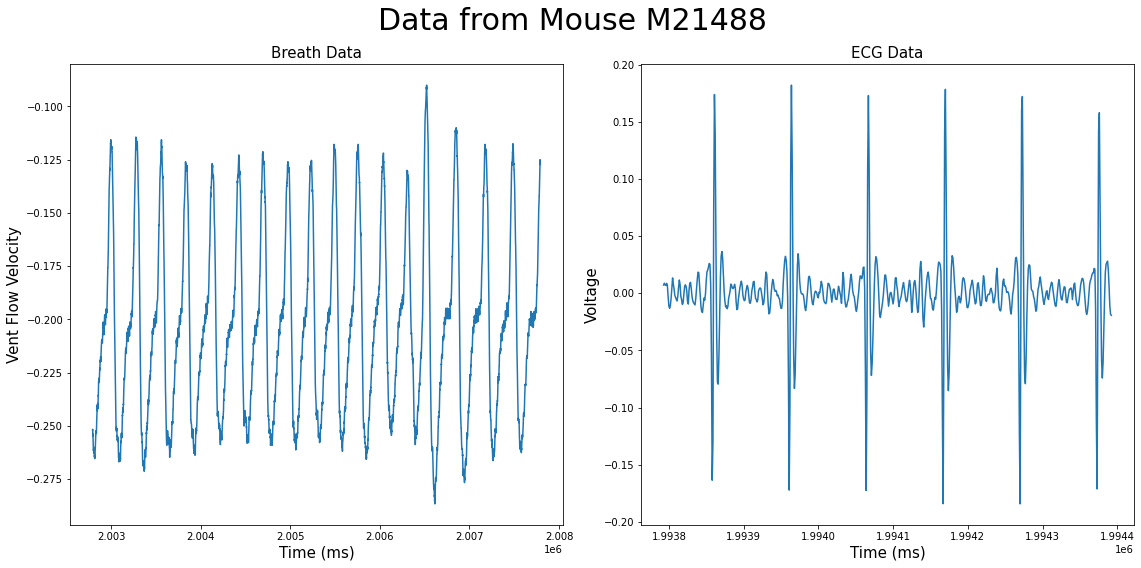

In [57]:
fig = plt.figure(figsize=(16,8))

plt.suptitle("Data from Mouse {}" .format(mouse), size = 30)

ax = fig.add_subplot(1,2,1)
ax.plot(phases_df[mouse][0]["index"][curr_range:curr_range+5000],phases_df[mouse][0]["Breathing_flow_signal"][curr_range:curr_range+5000])
ax.set_title("Breath Data", size=15)
ax.set_xlabel("Time (ms)", size=15)
ax.set_ylabel("Vent Flow Velocity", size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(hrt_phases_df[mouse][0]["index"][curr_range:curr_range+600],hrt_phases_df[mouse][0]["ECG"][curr_range:curr_range+600])
ax.set_title("ECG Data", size=15)
ax.set_xlabel("Time (ms)", size=15)
ax.set_ylabel("Voltage", size=15)

plt.tight_layout()

plt.savefig("data_sample.png", dpi=300)

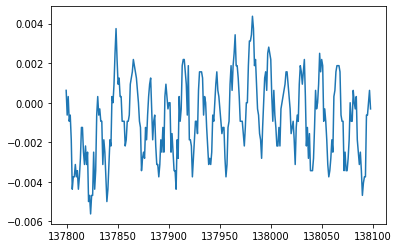

In [25]:
curr_range = 120000
mouse = "M21488"

plt.figure()
plt.plot(trials_raw[mouse]["raw"]["Breathing_flow_signal"][curr_range:curr_range+300])

In [3]:
def butter_bandpass(lowcutoff, highcutoff, fs, order):
    """
    This function takes in the filter parameters and
    does the simple calculations needed to account for the
    Nyquist frequency and using the scipy butter function
    to produce the numerator and polynomials of the IIR filter \n
    Inputs: \n
    1) lowcutoff - lower frequecy cutoff of bandpass filter
    2) highcutoff - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order \n
    Outputs: \n
    1) a - denominator polynomials of the IIR filter
    2) b - numerator polynomials of the IIR filter

    """
    nyq = 0.5 * fs  #nyquist frequency
    lowcutoff = lowcutoff / nyq        
    highcutoff = highcutoff / nyq
    a,b = butter(order, [lowcutoff, highcutoff], analog=False, btype='bandpass',output = 'ba')
    return a,b

def butter_bandpass_filter(data, lowcutoff, highcutoff, fs, order):
    """
    This function wraps the scipy functions needed to implement a 
    bandpass fillter and ultimately filters the signal \n
    Inputs: \n
    1) data - signal to be filtered
    2) lowcutoff - lower frequecy cutoff of bandpass filter
    3) highcutoff - upper frequecy cutoff of bandpass filter
    4) fs - sampling frequency
    5) order - filter order \n
    Outputs: \n
    1) filtered_signal

    """
    a,b = butter_bandpass(lowcutoff, highcutoff, fs, order=order)
    filtered_signal = filtfilt(a,b, data)
    return filtered_signal

def bandpass_filter(low, high, fs,order, signal, quiet = False):
    """
    This function bandpasses filters a given signal and has an option
    of plotting what the signal looks like before and after filtering \n
    Inputs: \n
    1) low - lower frequecy cutoff of bandpass filter
    2) high - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order 
    5) signal - signal to be filtered
    6) quiet - (default: False) boolean indicating whether or not to display signal before and after filtering \n
    Outputs: \n
    1) filtered_data

    """
    filtered_data = butter_bandpass_filter(signal, low, high, fs, order)

    if quiet == False:    
        plt.figure(figsize = (8,8))
        plt.plot(signal, label='Raw signal')
        plt.title("Unfiltered signal", size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

        plt.figure(figsize = (8,8))
        plt.plot(filtered_data)
        plt.title("Bandpass Filtered Signal, Cutoff = {}-{} Hz" .format(low,high), size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

    return filtered_data

def compute_timestamps(metadata, mouse_id, all = False, breath_only = False, phase = None, phase2 = None, phase3 = None, phase4 = None):
    """
    Given the required phase(s) and metadata, this function returns all the timestamps in which
    the given phase occurs in seconds as a list \n  

    Inputs:
    1) metadata
    2) mouse_id
    3) all - (default: False) boolean indicating whether all timestamps in experiments are requested as opposed to a select few
    4) breath_only - (default: False) Only if all == True. Excludes all HR Recovery timestamps when set to true
    5) phase, phase2, ... - all phases requested. At least 1 and at most 5 phases.

    if all == True, all timestamps in the experiment is returned \n
    Output formatted as follows: \n
        timestamps_in_s["trial"] = [list of timestamps] \n
        timestamps_in_s["other"]["timestamp"] = [all timestamps for non-trial onset] \n
        timestamps_in_s["other"]["comment"] = [names of all timestamps for not-trial onset]  \n
    if all == false, only specified timestamps are returned \n
    Output is just a 
    """
        
    if not all:
        #retreiving all relevant timestamps
        timestamps_in_hms = list(metadata[((metadata["Comment"] == phase) | (metadata["Comment"] == phase2) | (metadata["Comment"] == phase3) | (metadata["Comment"] == phase4)) & (metadata["source file"] == mouse_id)]["Time"])
        timestamps_in_s = []
        
        #converting timstamps from h:m:s to seconds
        for timestamp in timestamps_in_hms:
            processed_timestamp = re.split(':', timestamp)
            timestamp = [float(i) for i in processed_timestamp]   
            if len(timestamp) == 1:
                timestamps_in_s.append(timestamp[0])
            elif len(timestamp) == 2:
                timestamps_in_s.append(60*timestamp[0]+timestamp[1])
            elif len(timestamp) == 3:
                timestamps_in_s.append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])

        return timestamps_in_s

    else: #retreive all timestamps in experiment
        comments = list(metadata[metadata["source file"] == mouse_id]["Comment"]) 
        timestamps_in_hms = list(metadata[metadata["source file"] == mouse_id]["Time"]) 
        timestamps_in_s = defaultdict(lambda: defaultdict(str))

        if breath_only:  #exclude HR recovery timestamps
            other_comments = []
            other_timestamps = []
            for timestamp in range(0,len(comments)):
                if comments[timestamp] not in ["HR recovery","Hr recovery","HR recovery - No signal", "hr recovery"]:
                    other_comments.append(comments[timestamp])
                    other_timestamps.append(timestamps_in_hms[timestamp])
            timestamps_in_hms = other_timestamps
            comments = other_comments

        timestamps_in_s["trial"] = []
        timestamps_in_s["other"]["timestamp"] = []
        timestamps_in_s["other"]["comment"] = []

        #converting all hms timestamps 
        for stage in range(0,len(comments)):
            if comments[stage].isdecimal(): #if timestamps is trial onset, it is assigned elsewehere
                processed_timestamp = re.split(':', timestamps_in_hms[stage])
                timestamp = [float(i) for i in processed_timestamp]   
                if len(timestamp) == 1:
                    timestamps_in_s["trial"].append(timestamp[0])
                    timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                elif len(timestamp) == 2:
                    timestamps_in_s["trial"].append(60*timestamp[0]+timestamp[1])
                    timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                elif len(timestamp) == 3:
                    timestamps_in_s["trial"].append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])
                    timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                timestamps_in_s["other"]["comment"].append(comments[stage])
            else:
                if not comments[stage][1:].isdecimal():
                    processed_timestamp = re.split(':', timestamps_in_hms[stage])
                    timestamp = [float(i) for i in processed_timestamp]   
                    if len(timestamp) == 1:
                        timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                    elif len(timestamp) == 2:
                        timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                    elif len(timestamp) == 3:
                        timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                    timestamps_in_s["other"]["comment"].append(comments[stage])

        return timestamps_in_s


In [4]:
def clean_breath_data(raw_data, mouse, freqlow, freqhigh, filter_order, sampling_freq):
    """
    This function filters the raw breathing data and fixes an issue present in 3 of the mice \n

    Inputs: \n
    1) raw_data - 2D dictionary mapping each mouse ID to dataframe corresponding to its raw data
    2) mouse - mouse ID
    3) freqlow - lower bound for bandpass filter
    4) freqhigh - upper bound for bandpass filter
    5) filter_order - filter order
    6) sampling_freq - sampling frequency \n

    Outputs: \n
    1) data - raw_data dataframe corresponding to "mouse" but refined for use later
    2) filtered_data - array corresponding to breathing data from raw_data after filtering
    """
    
    #remove section of missing data from the only 3 mice with that problem
    timestamps = np.array(raw_data[mouse]["raw"]["Timestamp"])

    #time between each inspiration timestamps
    lengths = timestamps[1:] - timestamps[:-1]

    #excluding parts of breathing data missing readings for longer than a seconds
    if mouse in ["M20868", "M21267", "M21269"]:
        data = raw_data[mouse]["raw"][np.where(lengths>1)[0][0]+1:]
    else:
        data = raw_data[mouse]["raw"]

    #resetting index for consistency of the data with peak indices
    data.reset_index(inplace= True)

    #filtering data
    filtered_data = bandpass_filter(freqlow,freqhigh,sampling_freq,filter_order,data["Breathing_flow_signal"], quiet = True)
    
    return data, filtered_data

In [5]:
mouse = "M21488"

data1, filtered_data1 = clean_breath_data(trials_raw, mouse, 0.1, 15, 2, 1000)
data2, filtered_data2 = clean_breath_data(trials_raw, mouse, 1, 15, 2, 1000)

In [53]:
data2

,level_0,index,Timestamp,Breathing_flow_signal,O2_sensor_data,CO2_sensor_data,Chamber_temperature,ECG,Heart_Rate,Integrated_Flow,Breathing,trial_no
0,0,17799,17.799999,-0.213125,2.090625,-0.000312,35.0000,-0.000656,NaN,-3.593165,0.000120,-1.0
1,1,17800,17.801001,-0.215000,2.090313,0.000000,34.6875,0.000577,NaN,-3.593380,0.000112,-1.0
2,2,17801,17.802000,-0.215312,2.090937,-0.000312,34.6875,-0.000061,NaN,-3.593594,0.000112,-1.0
3,3,17802,17.802999,-0.214375,2.090937,-0.000312,34.3750,-0.000072,NaN,-3.593809,0.000103,-1.0
4,4,17803,17.804001,-0.214375,2.090625,0.000000,34.6875,-0.000398,NaN,-3.594024,0.000103,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5045897,5045897,5063696,5063.745117,-0.204063,2.086562,0.008750,34.6875,-0.005134,NaN,-972.729797,-0.169361,7.0
5045898,5045898,5063697,5063.746094,-0.201250,2.085938,0.008438,34.6875,-0.003884,NaN,-972.729980,-0.169498,7.0
5045899,5045899,5063698,5063.747070,-0.202500,2.085625,0.008750,34.3750,-0.000446,NaN,-972.730225,-0.169704,7.0
5045900,5045900,5063699,5063.748047,-0.201875,2.085625,0.009062,34.6875,-0.002634,NaN,-972.730408,-0.169979,7.0


[ 243  654  935 1250 1465 1693 1937 2202 2519 2830 3174 3557 4101 4565
 5125 5760 6290 6797 7246 7662 8095 8476 8948 9264 9637]
[ 243  654  935 1250 1465 1693 1937 2202 2519 2830 3174 3557 4101 4565
 5125 5760 6290 6797 7246 7662 8095 8476 8948 9264 9637]
[ 243  654  935 1250 1465 1693 1937 2202 2519 2830 3174 3557 4101 4565
 5125 5760 6290 6797 7246 7662 8095 8476 8948 9264 9637]
[ 243  654  935 1250 1465 1693 1937 2202 2519 2830 3174 3557 4101 4565
 5125 5760 6290 6797 7246 7662 8095 8476 8948 9264 9637]


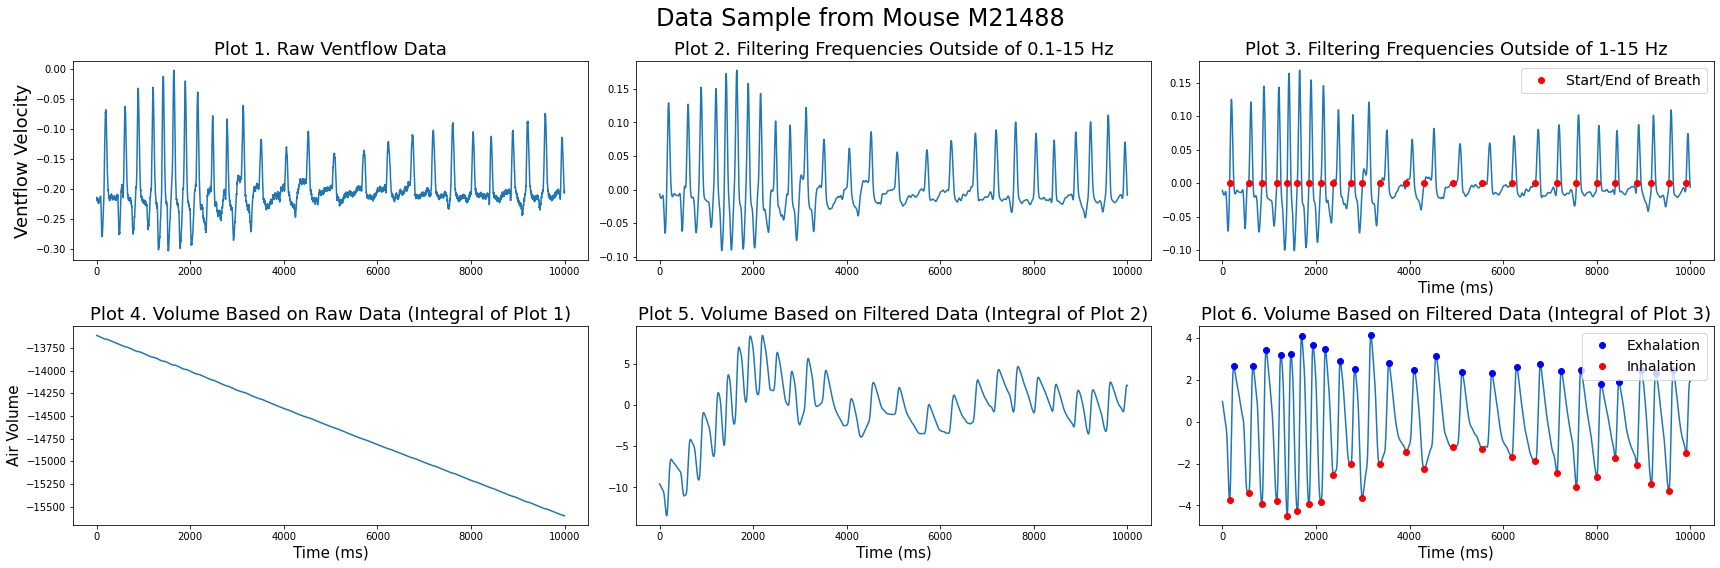

In [10]:
import operator

#finding all the timestamps of onset of inspiration and expiration
y_volume1 = cumtrapz(data1["Breathing_flow_signal"], x=time)
y_volume2 = cumtrapz(filtered_data1, x=time)
y_volume3 = cumtrapz(filtered_data2, x=time)

peaks, _ = find_peaks(y_volume3[starter:starter+10000], distance = 160, prominence = 1)
print(peaks)
peaks_magnitudes = y_volume3[starter:starter+10000][peaks]

peaks2, _ = find_peaks(-y_volume3[starter:starter+10000], distance = 160, prominence = 1)
print(peaks)
peaks_magnitudes2 = y_volume3[starter:starter+10000][peaks2]

fig = plt.figure(figsize = (24,8))

plt.suptitle("Data Sample from Mouse {}" .format(mouse), size = 24)

starter = 280000

ax = fig.add_subplot(2,3,1)

ax.plot(range(0,10000),data1["Breathing_flow_signal"][starter:starter+10000])
ax.set_title("Plot 1. Raw Ventflow Data", size=18)

ax.set_ylabel("Ventflow Velocity", size=18)

ax = fig.add_subplot(2,3,2)

ax.plot(filtered_data1[starter:starter+10000])
ax.set_title("Plot 2. Filtering Frequencies Outside of 0.1-15 Hz", size=18)



ax = fig.add_subplot(2,3,3)

ax.plot(filtered_data2[starter:starter+10000])
ax.set_title("Raw Ventflow Data", size=14)
ax.set_xlabel("Time (ms)", size=15)
ax.plot(peaks2, np.zeros(len(peaks2)), "o", c = "red", label = "Start/End of Breath")
ax.set_title("Plot 3. Filtering Frequencies Outside of 1-15 Hz", size=18)
ax.legend(fontsize=14)

from scipy.integrate import cumtrapz
from scipy.signal import find_peaks

time = data1["index"]

ax = fig.add_subplot(2,3,4)

ax.plot(y_volume1[starter:starter+10000])
ax.set_title("Plot 4. Volume Based on Raw Data (Integral of Plot 1)", size=18)
ax.set_xlabel("Time (ms)", size=15)
ax.set_ylabel("Air Volume", size = 15)

ax = fig.add_subplot(2,3,5)

ax.plot(y_volume2[starter:starter+10000])
ax.set_title("Plot 5. Volume Based on Filtered Data (Integral of Plot 2)", size=18)
ax.set_xlabel("Time (ms)", size=15)

ax = fig.add_subplot(2,3,6)

peaks, _ = find_peaks(y_volume3[starter:starter+10000], distance = 160, prominence = 1)
print(peaks)
peaks_magnitudes = y_volume3[starter:starter+10000][peaks]

peaks2, _ = find_peaks(-y_volume3[starter:starter+10000], distance = 160, prominence = 1)
print(peaks)
peaks_magnitudes2 = y_volume3[starter:starter+10000][peaks2]

ax.plot(y_volume3[starter:starter+10000])
ax.plot(peaks, peaks_magnitudes, "o", c = "blue", label = "Exhalation")
ax.plot(peaks2, peaks_magnitudes2, "o", c = "red", label = "Inhalation")
ax.set_title("Plot 6. Volume Based on Filtered Data (Integral of Plot 3)", size=18)
ax.set_xlabel("Time (ms)", size=15)
ax.legend(fontsize=14, loc="upper right")


def find_breath_timestamps(raw_data: dict, mouse: str, filtered_data, peak_prominence : float, p2p_min: float):
    """
    Tthis function returns the index of the first breath indicating when the mouse was first mounted on the rig.
    This function also returns the inspiration timestamps of all the breaths \n

    Inputs: \n
    1) raw_data - 2D dictionary mapping each mouse ID to dataframe corresponding to its raw data
    2) mouse - mouse ID
    3) filtered_data - array corresponding to breathing data from raw_data after filtering
    4) peak_prominence - value indicating how much higher the peaks we're looking for need to be than data around it
    5) p2p_min - minimum distance between two peaks 

    Outputs: \n
    1) mouse_online - timestamp during which mouse was mounted onto rig
    2) breath_timestamps - all inspiration timestamps 
    3) expiration_timestamps - all expiration timestamps
    """

    time = raw_data["index"]

    #finding all the timestamps of onset of inspiration and expiration
    y_volume = cumtrapz(filtered_data, x=time)

    peaks, _ = find_peaks(-y_volume, distance = p2p_min, prominence = peak_prominence)
    peaks = peaks + time[0]
    exp_peaks, _ = find_peaks(y_volume, distance = p2p_min, prominence = peak_prominence)
    exp_peaks = exp_peaks + time[0]
    
    #taking care of inconsistencies in a couple of the data files
    calibr = compute_timestamps(metadata, mouse, phase = "Cal 20 Room Air")
    if mouse not in ["M20868", "M21267", "M21269"]:
        narrowed_peaks = peaks[peaks > (calibr[-1]*1000 + 5e4)]
    else:
        narrowed_peaks = peaks

    #identifying where exactly in
    #the data the mouse is actually mounted onto the machine
    for peak in range(0,len(peaks)):
        distance = narrowed_peaks[peak+40] - narrowed_peaks[peak]
        if distance < 40e3:
            starter_peak = peak
            break
    
    #timestamp where the mouse was mounted on the rig
    mouse_online = raw_data["Timestamp"].iloc[narrowed_peaks[starter_peak]]

    #finding all the breaths detected after mouse mounted on rig
    breath_timestamps = narrowed_peaks[starter_peak:]
    expiration_timestamps = exp_peaks[exp_peaks > breath_timestamps[0]]

    peaks1=breath_timestamps
    peaks0=expiration_timestamps

    #accounting for all instances in which consective expirations were detected with
    #no insipirations inbetween and vice versa
    expiration =  [1] * len(peaks0)
    inspiration =  [-1] * len(peaks1)

    breath_out = list(zip(list(peaks0), expiration))
    breath_in = list(zip(list(peaks1), inspiration))

    all_breaths = breath_out + breath_in
    all_breaths.sort(key=operator.itemgetter(0))

    timestamp_type = list(zip(*all_breaths))
    test = np.array(timestamp_type[1][:-1]) + np.array(timestamp_type[1][1:])

    consecutives = np.where(test != 0)[0]

    for index in consecutives:
        del all_breaths[index+1]
        consecutives -= 1

    all_timestamps = np.array(list(zip(*all_breaths))[0])
    breath_timestamps = all_timestamps[0::2]
    expiration_timestamps = all_timestamps[1::2]

    #if last peak deteced was an inspiration, remove it. Making sure last peak detected was expiration
    if len(breath_timestamps) > len(expiration_timestamps):
        breath_timestamps = breath_timestamps[:-1]
        expiration_timestamps = expiration_timestamps[:-1]
    else: #removing last expiration since last inspiration will be discarded later
        expiration_timestamps = expiration_timestamps[:-1]

    return mouse_online, breath_timestamps, expiration_timestamps, time[0]

#online1, br_timstps1, expiration_timstmps1, starter1 = find_breath_timestamps(data1["Breathing_flow_signal"], mouse, data1["Breathing_flow_signal"], 160, 0.2)
#online2, br_timstps2, expiration_timstmps2, starter2 = find_breath_timestamps(data1["Breathing_flow_signal"], mouse, filtered_data1, 160, 0.2)
#online3, br_timstps3, expiration_timstmps3, starter3 = find_breath_timestamps(data2, mouse, filtered_data2, 1, 160)

plt.tight_layout()
plt.savefig("Filtering_Data2.jpg", dpi= 300)

In [14]:
len(filtered_data)

5045902

In [12]:
data

,level_0,index,Timestamp,Breathing_flow_signal,O2_sensor_data,CO2_sensor_data,Chamber_temperature,ECG,Heart_Rate,Integrated_Flow,Breathing,trial_no
0,0,17799,17.799999,-0.213125,2.090625,-0.000312,35.0000,-0.000656,NaN,-3.593165,0.000120,-1.0
1,1,17800,17.801001,-0.215000,2.090313,0.000000,34.6875,0.000577,NaN,-3.593380,0.000112,-1.0
2,2,17801,17.802000,-0.215312,2.090937,-0.000312,34.6875,-0.000061,NaN,-3.593594,0.000112,-1.0
3,3,17802,17.802999,-0.214375,2.090937,-0.000312,34.3750,-0.000072,NaN,-3.593809,0.000103,-1.0
4,4,17803,17.804001,-0.214375,2.090625,0.000000,34.6875,-0.000398,NaN,-3.594024,0.000103,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5045897,5045897,5063696,5063.745117,-0.204063,2.086562,0.008750,34.6875,-0.005134,NaN,-972.729797,-0.169361,7.0
5045898,5045898,5063697,5063.746094,-0.201250,2.085938,0.008438,34.6875,-0.003884,NaN,-972.729980,-0.169498,7.0
5045899,5045899,5063698,5063.747070,-0.202500,2.085625,0.008750,34.3750,-0.000446,NaN,-972.730225,-0.169704,7.0
5045900,5045900,5063699,5063.748047,-0.201875,2.085625,0.009062,34.6875,-0.002634,NaN,-972.730408,-0.169979,7.0
